In [4]:
import sys
print(sys.version)
fid=open('requirements.txt','r'); req=fid.readlines(); fid.close()

!pip freeze > technical/inst_pip.txt
fid=open('technical/inst_pip.txt','r'); inst_pip=fid.read(); fid.close()
!conda list --export > technical/inst_conda.txt
fid=open('technical/inst_conda.txt','r'); inst_conda=fid.read(); fid.close()

print('Packages installed: \x1b[32m same version \x1b[33m different version \x1b[31m not installed')
for pack in req:
    if pack in inst_pip+inst_conda:
        print("\x1b[32m{}".format(pack))
    elif pack[:pack.find('==')].lower() in inst_pip+inst_conda:
        print("\x1b[33m{}".format(pack))
    else:
        print("\x1b[31m{}".format(pack))

# inst_pip+inst_conda

3.5.6 |Anaconda custom (64-bit)| (default, Aug 26 2018, 21:41:56) 
[GCC 7.3.0]
Packages installed:  same version  different version  not installed
Cartopy==0.14.2

h5py==2.6.0

Keras==1.2.2

numpy==1.12.1

opencv-python==3.2.0.6

pandas==0.19.1

Pillow==3.1.2

scikit-image==0.12.3

tables==3.4.2

tensorflow==1.10.0rc0



In [5]:
deepmoon_path='../DeepCrater/'
data_path = '../data/'
if deepmoon_path not in sys.path:
    sys.path.append(deepmoon_path)
if data_path not in sys.path:
    sys.path.append(data_path)    

In [6]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image    # Requires Pillow
import urllib
import cartopy

In [7]:
# check if exist here and download data from Zenodo: 
Files = ["dev_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the validation dataset.
         "dev_images.hdf5", # - Input DEM images and output targets of the validation dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.
         "LunarLROLrocKaguya_118mperpix.png", # - LRO LOLA and Kaguya Terrain Camera DEM Merge, downsampled to 118 m/pixel and 8 bits/pixel.  The original file can be found at: https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LrocKaguya_DEMmerge_60N60S_512ppd.
         "model_keras1.2.2.h5", # - Keras model weights for the DeepMoon CNN, compatible with Keras version 1.2.2.
         "model_keras2.h5", # - Keras model weights for the DeepMoon CNN, compatible with Keras versions >= 2.0.
         "post-processed_sample_images.zip", # - Contains a set of sample images from the test dataset with the Moon DEM image, new identified craters, CNN target predictions, and ground-truth. The new craters from these images were used to estimate the post-processed false positive rate. See Instructions.txt in .zip file for more details.
         "post-processed_test_craters.npy", # - numpy file containing post-processed craters identified by our pipeline on the test set. Each crater entry is arranged as a tuple: (longitude, latitude, radii), where longitude and latitude are in degrees, and radius is in kilometres. 
         "test_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the test dataset.
         "test_images.hdf5", # - Input DEM images and output targets of the test dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.
         "train_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the training dataset.
         "train_images.hdf5"] # - Input DEM images and output targets of the training dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.]
Files = Files[2:7]
for file in Files: 
  if os.path.isfile(data_path+file): 
    print('File {} exist in library!'.format(file))
  else: 
    print('File {} does not exist in library. downloading now from Zenodo ...'.format(file))
    URL = "https://zenodo.org/record/1133969/files/"+file
    !wget -P "$data_path" "$URL"
    print('Downloaded into {}'.format(data_path+file))

# download albedo map: 
if not os.path.isfile(data_path+'Clementine_albedo_simp750.jpg'): 
    !wget -P $data_path https://upload.wikimedia.org/wikipedia/commons/e/ea/Clementine_albedo_simp750.jpg
if not os.path.isfile(data_path+'moonmercator.jpg'):
    !wget -P $data_path http://btc.montana.edu/ceres/worlds/landform/moonmercator.jpg
albedo = Image.open(data_path + "/Clementine_albedo_simp750.jpg")

File LunarLROLrocKaguya_118mperpix.png exist in library!
File model_keras1.2.2.h5 exist in library!
File model_keras2.h5 exist in library!
File post-processed_sample_images.zip exist in library!
File post-processed_test_craters.npy exist in library!


# Generate train/dev/test sets out of SLDEM 120 m/pix

In [9]:
import input_data_gen as igen
import utils.processing as proc
Image.MAX_IMAGE_PIXELS = 3000000000

# Read source image.
o_img = Image.open(data_path + "/LunarLROLrocKaguya_118mperpix.png").convert("L")
# Read and combine the LROC and Head datasets (stored under ../catalogues)
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc=deepmoon_path + "/catalogues/LROCCraters.csv",
                                             filehead=deepmoon_path + "/catalogues/HeadCraters.csv")
source_cdim = [-180., 180., -60., 60.]
sub_cdim = [0., 20., 0., 30.]
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(o_img, source_cdim, sub_cdim)
craters = igen.ResampleCraters(craters, sub_cdim, img.size[1])

fn = 'test_SLDEM120'
# Generate 10 image/target sets, and corresponding crater dataframes.  np.random.seed is set for consistency.
igen.GenDataset(img, craters, data_path + '/' + fn, 
                cdim=sub_cdim, amt=10, rawlen_range=[256, 2000], seed=1337, verbose=True)

In [8]:
gen_imgs = h5py.File(data_path + '/' + fn + '_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]

In [10]:
img_ar = np.asarray(o_img)
# np.unique(img_ar[:,:])

In [15]:
img_ar.shape

(30720, 92160)

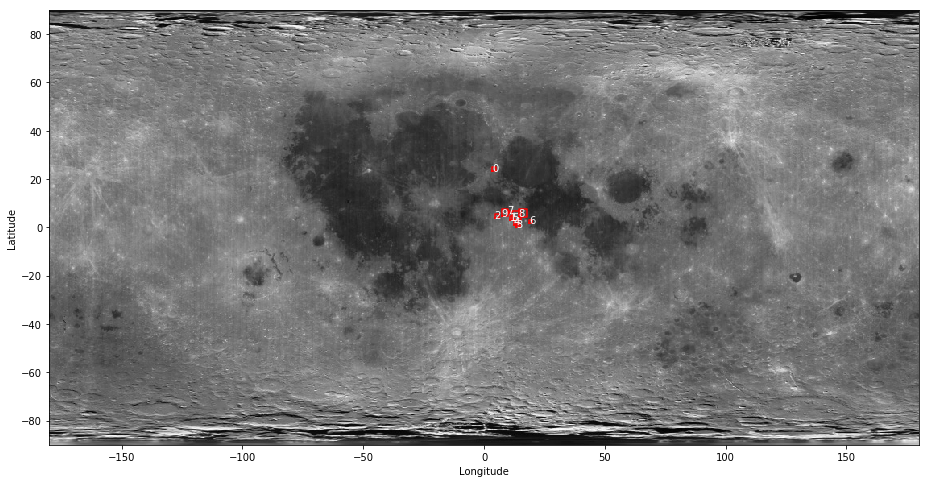

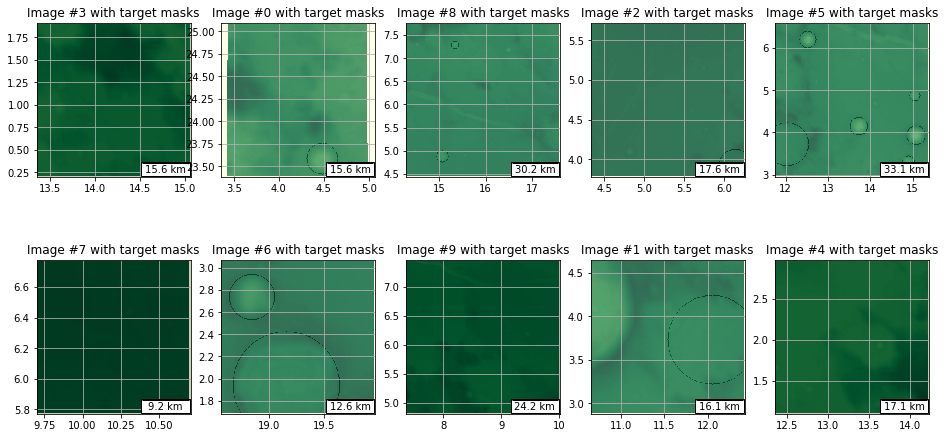

In [9]:
import utils.maplot

%matplotlib inline
# See 5 images of the set we produced: 
show_subset = np.random.choice(range(len(gen_imgs['cll_xy'])),size=10, replace=False)
fig = plt.figure(figsize=[16, 8])
al_map = plt.imshow(albedo, extent=[-180, 180, -90, 90], aspect="equal", cmap="Greys_r")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in show_subset:
  llon,rlon,llat,ulat=gen_imgs['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='w')
   
fig2 = plt.figure(figsize=[16, 8])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  utils.maplot.plot_map_w_scalebar2(ax,gen_imgs,im_num,mask=True)

# Prediction by the model

In [9]:
import keras
keras.__version__

Using TensorFlow backend.


'1.2.2'

In [10]:
from keras.models import load_model
sys.path.append("%s/utils/"%deepmoon_path)
import template_match_target as tmt

# Use the commented out line for Keras 2.0+
# model = load_model(zenodo_path + '/model_keras2.h5')
model = load_model(data_path + '/model_keras1.2.2.h5')

/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


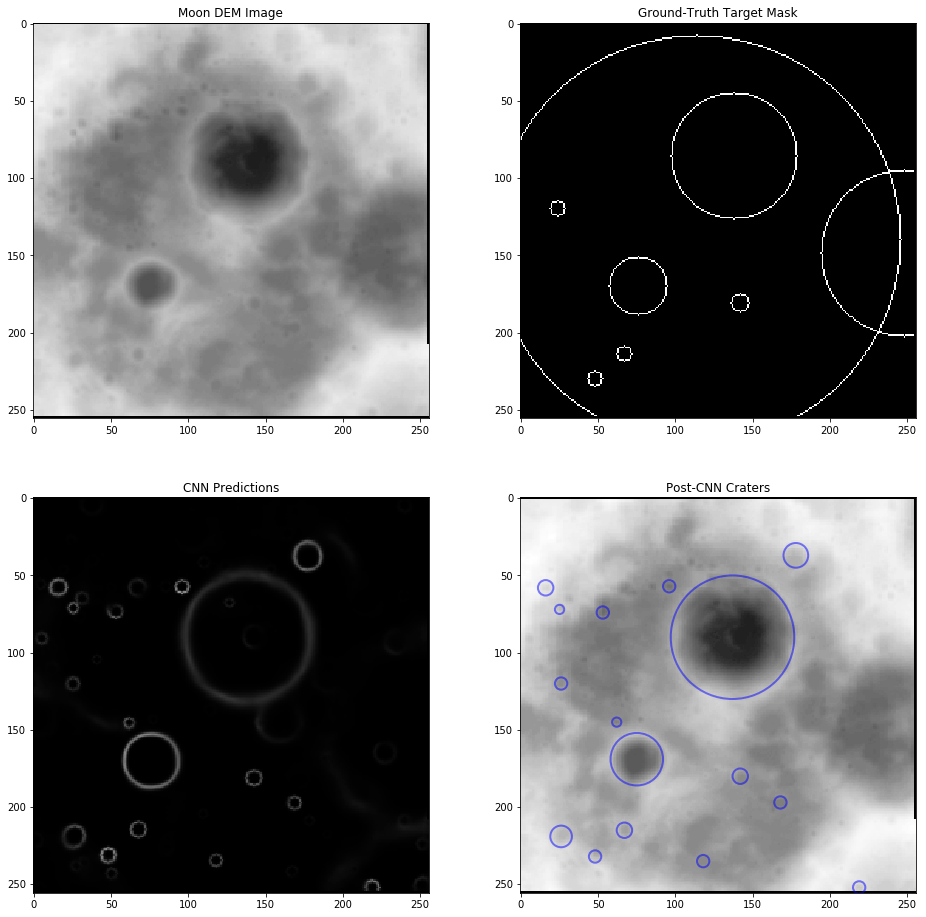

In [11]:
# Use the CNN to make a prediction.  We use [iwant:iwant + 1] to keep input as a 4D tensor.
# Input data MUST BE PREPROCESSED (see proc.preprocess, above) before being passed into model.predict
iwant = show_subset[1]
pred = model.predict(sd_input_images[iwant:iwant + 1])
# Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=3.)
#
fig = plt.figure(figsize=[16, 16])
[[ax1, ax2], [ax3, ax4]] = fig.subplots(2, 2)
ax1.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap='Greys_r', vmin=0, vmax=1.1)
ax2.imshow(sd_target_masks[iwant].squeeze(), origin='upper', cmap='Greys_r')
ax3.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax4.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap="Greys_r")
for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax4.add_artist(circle)
ax1.set_title('Moon DEM Image')
ax2.set_title('Ground-Truth Target Mask')
ax3.set_title('CNN Predictions')
ax4.set_title('Post-CNN Craters')
plt.show()